![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Computer Vision Concepts Continued

Kevin now has a decent understanding of CNNs and how they work, but his model is still not performing as well as he would like. He's been reading up on some techniques to improve his model's performance and is excited to try them out. 

One particularly good article on this is topic is Ayush Thakur and Aritra Roy Gosthipaty's article [Simple Ways to Tackle Class Imbalance](https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk) (Thakur & Gosthipaty). Look through this article, and the explanations of the methods.


## [!!!INSERT IMAGE ABOUT CLASS IMBALANCE!!!]


## 1. Import the libraries we will use

In [1]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
from sklearn.model_selection import train_test_split

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import the ImageDataGenerator class from Keras module in TensorFlow.
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

from sklearn.utils import class_weight

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhace readability. 
import helpers_01

# Load the TensorBoard notebook extension
%load_ext tensorboard

2024-05-30 14:26:23.353326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 14:26:23.353382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 14:26:23.354018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 14:26:23.359538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Exploring the data

As before we'll use our helper function `helpers_01.manage_data` to make sure we have the data and set the `data_path`.

In the last notebook, Kevin noticed that his model had a big problem: it thought everything was wasps! Let's explore the data a bit and see if we can figure out why.

First let's make a histogram of the number of images in each class. That should give us a good idea of how balanced the dataset is.

In [2]:
# Chech for the data.
data_path = helpers_01.manage_data() 

Found data at /blue/practicum-ai/share/data/bee_vs_wasp.


Category wasp: 4,943 images, or 43.3% of total images.
Category bee: 3,184 images, or 27.9% of total images.
Category other_insect: 2,439 images, or 21.4% of total images.
Category other_noinsect: 856 images, or 7.5% of total images.
************************************


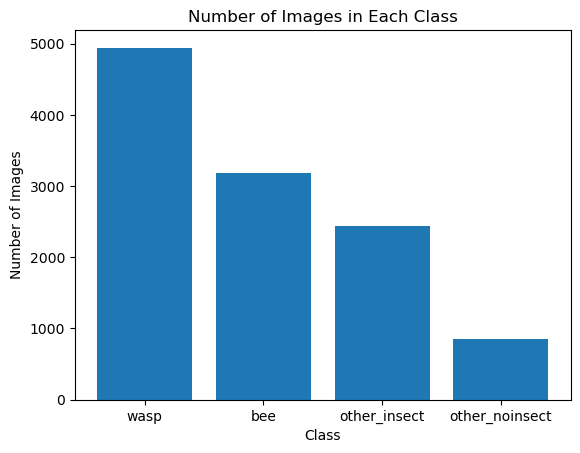

In [3]:
# Make a histogram of the number of images in each class
def make_hist_get_max(data_path):
    # Get the class names
    class_names = os.listdir(data_path)

    # Initialize an empty list to store the number of images in each class
    num_images = []

    # Loop through each class
    for class_name in class_names:
        # Get the list of images in the class
        images = os.listdir(os.path.join(data_path, class_name))
        # Append the number of images in the class to the list
        num_images.append(len(images))

    # Put the number of images in each class in descending order
    num_images, class_names = zip(*sorted(zip(num_images, class_names), reverse=True))

    total_images = sum(num_images)
    
    # Print the number of images in each class
    for i in range(len(class_names)):
        percentage = (num_images[i] / total_images) * 100
        print(f'Category {class_names[i]}: {num_images[i]:,} images, or {percentage:.1f}% of total images.')

    print("************************************")       
        
    # Create a histogram of the number of images in each class
    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.show()

    return num_images

num_images = make_hist_get_max(data_path)

Yikes! That's a pretty big class imbalance--there are almost 5,000 wasp images and less than 1,000 other non-insect images. Large class imbalances tend to make models biased towards the majority class. This is likely why Kevin's model was predicting everything as wasps. Let's try to fix this!

Part of the issue with imballanced data is that the algorithm can do fairly well by never predicting the rare class(es).

As an example, let's imaging we are looking at a rare disease. If only 5% of the data are from the disease state, a model can be 95% accurate by never predicting disease. That 95% accuracy sounds good, but the model is not too helpful!

## 3. Class Weighting

The first method we will implement is adding class weighting. As Thakur & Gosthipaty write:
> One of the easiest ways to counter class imbalance is to use class weights wherein we give different weightage to different classes. The number of samples in the classes is considered while computing the class weights. We apply more significant weight to a minority class, which places more emphasis on that class. The classifier thus learns equally from both the classes. [Their example had only two classes]
>
> Class weights regularize the loss function. By misclassifying the minority class, a higher loss is incurred by the model since the minority class has a higher weight. This forces the model to learn representations for the minority class. This, however, comes at a price of slightly reduced performance for the majority class.

Note that they were dealing with two classes, here, we have four. Our code will handle datasets with different numbers of classes.

We'll start using a slightly modified version of the `load_display_data` function we used in the first notebook. It is now in the `helpers_01` module we imported. We will pass `show_pictures=False` to skip that.


In [4]:
X_train, X_valid = helpers_01.load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=False)

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.


2024-05-30 14:29:19.655418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
Category bee: 2552 images or 27.9% of total images.
Category other_insect: 1945 images or 21.3% of total images.
Category other_noinsect: 698 images or 7.6% of total images.
Category wasp: 3943 images or 43.1% of total images.


## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [5]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                          

## 5. Compile and Train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

In [21]:

# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(train_set, val_set, model,
                        loss='categorical_crossentropy',
                        optimizer='Adam', learning_rate=0.0001, epochs=10, callbacks=[],
                        use_class_weights=False):
    '''Compiles and trains the model. 
          Takes in an training set, a validation set, model, loss function, optimizer, learning rate,
          and epochs.
          Returns the compiled model and training history.'''
    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss function: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print(f"  - Using these callbacks: {callbacks}")
    print(f"  - Using class weights: {use_class_weights}")
    print("***********************************************************************")
    
    kwargs={} # Used to add optional arguments to the model.fit call 
    
    # Compile the model
    
    opt= load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    
    if use_class_weights:
        # Calculate class weights to deal with imballance
        class_names = list(train_set.class_names)
        class_numbers= list(range(0,len(class_names)))
        cls_wt = class_weight.compute_class_weight('balanced', 
                                      classes=class_names, 
                                      y=train_set.class_names)

        # Make for printing
        class_weights = dict(zip(class_names, cls_wt))
        print(f'Using class weights: {class_weights}')

        # Remake with numeric categories
        class_weights = dict(zip(class_numbers, cls_wt))
        print(f'Using class weights: {class_weights}')
    print(type(train_set))
    # Train the model
    history = model.fit(train_set, epochs=epochs, validation_data=val_set, class_weight=class_weights, callbacks=[callbacks])
    
    return model, history

model, history = compile_train_model(X_train, X_valid, model,  use_class_weights=True)

***********************************************************************
Compile and Train the model:
  - Using the loss function: categorical_crossentropy.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
  - Using these callbacks: []
  - Using class weights: True
***********************************************************************
Using class weights: {'bee': 1.0, 'other_insect': 1.0, 'other_noinsect': 1.0, 'wasp': 1.0}
Using class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Epoch 1/10


ValueError: in user code:

    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


## 6. Evaluate the model

Now that we have trained our model let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
286/286 [==============================] - 26s 90ms/step - loss: 0.4729 - accuracy: 0.8126
Test loss: 0.47289007902145386
Test accuracy: 0.8126094341278076


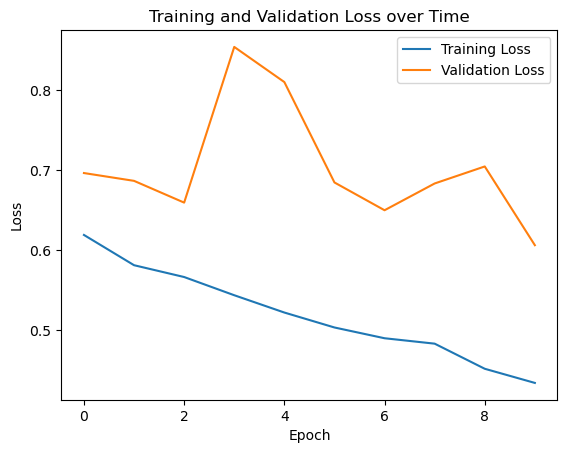

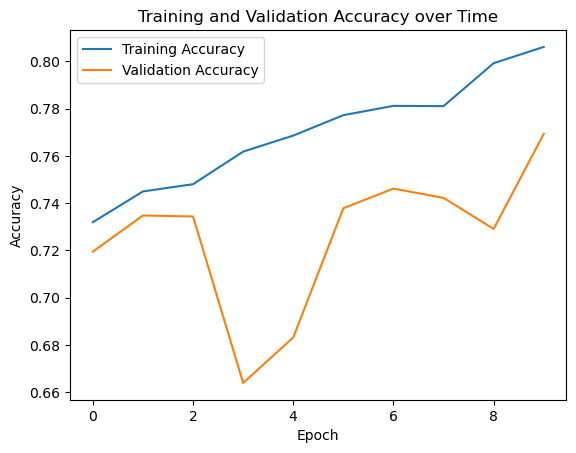

72/72 [==============================] - 7s 90ms/step


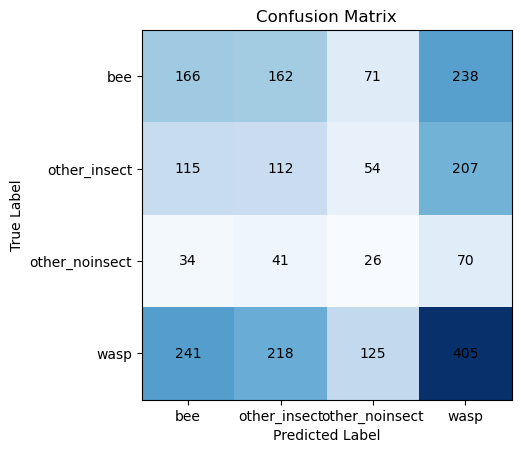

In [20]:
def evaluate_model(train_set, val_set, model, history, num_classes=4):
    '''Evaluates a model. 
          Takes in a train_set, val_set, model, history, number of classes.'''
    print("***********************************************************************")
    print("Evaluate the model:")
    print("***********************************************************************")
    # Evaluate the model
    loss, accuracy = model.evaluate(train_set)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

    # Plot the training and validation loss over time
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the training and validation accuracy over time
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    class_names = list(train_set.class_indices.keys()) # Get the class names
    
    y_pred = np.argmax(model.predict(val_set), axis=-1) # Make predictions on the test set

    num_val_samples = val_set.samples  # total number of validation samples
    batch_size = val_set.batch_size  # batch size

    # Calculate the number of batches
    num_batches = np.ceil(num_val_samples / batch_size)
    num_batches = int(num_batches)

    # Get the true labels
    y_true = np.concatenate([y for x, y in (next(val_set) for _ in range(num_batches))], axis=0)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred)
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(num_classes),class_names)
    plt.yticks(range(num_classes), class_names)
    # plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()

evaluate_model(train_generator, val_generator, model, history)


.

## 3. Stratified sampling

There are many ways to address this issue. One of which is stratified sampling. This is a technique where we sample from the dataset in such a way that the distribution of classes in the sample is the same as the distribution of classes in the dataset. This way, we can ensure that the model sees a balanced dataset during training.

Let's try this out. We'll use the `train_test_split` function from `sklearn` to split the data into training and validation sets. We'll set the `stratify` parameter to the labels so that the function samples in a stratified manner.



In [19]:
def count_class(counts, batch, classes):
    '''Count number of samples per class in a batch'''
    for i in range(classes):
        cc = tf.cast(batch[1] == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)


def load_display_data(path, batch_size=32, shape=(80,80,3), show_pictures=True):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")
    # Define the directory path
    directory_path = path
    
    # Define the batch size
    batch_size = batch_size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]
    
    # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels='inferred',
        label_mode='int'
    )
    
    X_test = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels='inferred',
        label_mode='int'
    )

    if show_pictures:
        # Get the class names
        class_names = X_train.class_names
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            for images, labels in X_train.take(2):
                images = images.numpy()
                labels = labels.numpy()

                # Filter images of the current class
                class_images = images[labels == i]
                
                # Number of images to show.
                # Limited by number of this class in the batch or specific number
                num_images = min(len(class_images), 3)
                
                for j in range(num_images):
                    ax = plt.subplot(1, num_images, j + 1)
                    plt.imshow(class_images[j].astype("uint8"))
                    plt.title(class_name)
                    plt.axis("off")
            plt.show()
            
  
    #Get and print counts by class
    # Initialize counts
    counts = [0] * len(X_train.class_names)
    class_names=list(X_train.class_names)
    
    # Iterate through the dataset batch by batch
    for batch in X_train:
        count_class(counts, batch, len(X_train.class_names))
    
    total=sum(counts)
    # Print the counts
    for i, count in enumerate(counts):
        print(f"Category {class_names[i]}: {count} images or {count/total*100:.1f}% of total images.")
      
    return X_train, X_test

load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=False)

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
Category bee: 2552 or 27.9%
Category other_insect: 1945 or 21.3%
Category other_noinsect: 698 or 7.6%
Category wasp: 3943 or 43.1%


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [7]:
# Create a function that loads data for an object detection model
def prep_display_data(path, batch_size=32, shape=(80,80,3), show_pictures=False, stratify=True, normalize=True, ):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")
    
    batch_size = batch_size  # Define the batch size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]

    # Get the class names
    class_names = os.listdir(path)

    images = [] # Initialize the images list
    labels = [] # Initialize the labels list

    # Get the images and labels to use for training and validation
    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            images.append(image_path)
            labels.append(class_name)

    # Print the number of number of images per class
    for class_name in class_names:
        print(f'Number of {class_name} images: {labels.count(class_name)}:,')
    
    if stratify: # Use sklearn's train_test_split function to split the data into training and testing sets
        # Split the data in a stratified manner
        X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)
    else:
        # Split the data randomly
        X_train, X_val = train_test_split(images, test_size=0.2)

    # Build the DataFrames for the training and validation sets
    train_df = pd.DataFrame(list(zip(X_train, y_train)), columns=['image', 'class'])
    val_df = pd.DataFrame(list(zip(X_val, y_val)), columns=['image', 'class'])
    
    if normalize:
        # Define the ImageDataGenerator class with rescaling for each channel
        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)
    else:
        train_datagen = ImageDataGenerator()
        val_datagen = ImageDataGenerator()
    
    # Define the training and validation data generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)


    if show_pictures:
        # Get the class names
        class_names = list(train_generator.class_indices.keys())
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            
            # Get a single batch to use for display
            images, labels = train_generator.next()

            # Un-normalize the images for display if normalization was used
            if normalize:
                images = images * 255

            # Filter images of the current class
            class_images = images[labels[:, i] == 1]
                
            # Number of images to show. We don't want to show more than 3 images.
            num_images = min(len(class_images), 3)
                
            for j in range(num_images):
                ax = plt.subplot(1, num_images, j + 1)
                plt.imshow(class_images[j].astype("uint8"))
                plt.title(class_name)
                plt.axis("off")
            plt.show()
            
    for class_name  in class_names:
        count = y_train.count(class_name)
        print(f'Number of {class_name} images: {count}')

    return X_train, X_val, train_generator, val_generator

X_train, X_val, train_generator, val_generator = prep_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=False, stratify=True, normalize=True)


***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Number of wasp images: 4943:,
Number of other_insect images: 2439:,
Number of bee images: 3184:,
Number of other_noinsect images: 856:,
Found 9136 validated image filenames belonging to 4 classes.
Found 2285 validated image filenames belonging to 4 classes.
Number of wasp images: 3954
Number of other_insect images: 1951
Number of bee images: 2547
Number of other_noinsect images: 685


/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


## 7. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [ ]:
def the_whole_shebang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_val, train_generator, val_generator = prep_display_data(data_path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    model, history = compile_train_model(train_generator, val_generator, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
    evaluate_model(train_generator, val_generator, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

In [ ]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss= 'categorical_crossentropy' # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

## 8. EDIT OR REMOVE A look inside CNNs
To get an idea for what is happening *inside* this model, let's look at a **feature map**. Below we see a vertical edge detection filter applied to a sunflower picture, resulting in a feature map of that image.

![](images/01.1_filter_image.jpg)

Imagine you're a detective investigating a scene.  A feature map is like a sketch you create, focusing on specific details that might be clues to solving the case.  In a CNN, the "case" is recognizing patterns in an image, and the feature maps capture these patterns at different levels of complexity. Early layers might create feature maps that detect basic edges, corners, or blobs of color. As the network progresses through more layers, the feature maps become more intricate, combining these simpler features to represent more complex objects or shapes.

Getting a bit more technical, a feature map is a 2D array of activations produced by applying a convolutional filter to an input image or a previous layer's feature map. It essentially captures the presence and strength of specific visual features the filter is optimized to detect within the input.

The **convolutional filters** (also just called "filters" or "kernels") are small matrices containing learnable weights. The filter "slides" across the input image, performing element-wise multiplication with the underlying image data at each position. The result of the multiplication is then passed through an activation function (like ReLU) to introduce non-linearity and help the network learn complex features. A convolutional layer typically has multiple filters, each generating a separate feature map. These feature maps capture different aspects of the input, providing a richer representation of the image.

**NOTE**: The above sunflower example could potentially be a bit misleading. While a model *can* and probably will develop a vertical edge detection filter, the model develops it's filter's weights through the same backpropagation process as other deep neural networks. Most of the filters, and their resulting feature maps, will not be as easily interpretable as the vertical edge detection filter.

In [ ]:
# Get the filters from the first layer of the model
filters = model.layers[0].get_weights()[0]

# Get the first batch of images from the training set
conv_images = X_train.take(1)
plt.figure(figsize=(10, 10))
for images, labels in conv_images:
    images = images.numpy()
    labels = labels.numpy()

# Get the feature maps from the first layer of the model
feature_maps = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)
feature_maps = feature_maps.predict(images)

# Normalize the filters and feature maps. This will make the images more clear.
normal_filters = (filters - filters.min()) / (filters.max() - filters.min())
normal_feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

# Display the filters, images and feature maps
plt.figure(figsize=(10, 10))

# ----- Filters -----
for i in range(3):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns, position 1 to 3 
    plt.imshow(normal_filters[:, :, :, i], cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')

# ----- Original Images -----
for i in range(3):
    plt.subplot(3, 3, i + 4)  # Position 4 to 6
    plt.imshow(images[i].astype("uint8"))
    plt.title(f'Original Image {i}')
    plt.axis('off')

# -----  Feature Maps (Image 1) -----
for i in range(3):
    plt.subplot(3, 3, i + 7)  # Position 7 to 9
    plt.imshow(normal_feature_maps[1, :, :, i], cmap='gray')
    plt.title(f'Feature Map 1, Channel {i}')
    plt.axis('off')

plt.suptitle('Visualizing a CNN')  # Overall title for the plot
plt.tight_layout()  # Adjust spacing to prevent overlaps
plt.show()


Just as with the other hyperparameters in Section 7 above, the number of filters, the size of the filters, and the stride of the filters are all hyperparameters that can be adjusted. You can also add or remove convolutional and pooling layers, or add dropout layers. Dropout layers are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. Here is an example of how to add a dropout layer to the model:
    
```python
    # Import the Dropout layer
    from tensorflow.keras.layers import Dropout

    # Existing Conv2D layer
    # Dropout layer with a 50% dropout rate
    model.add(Dropout(0.5)) 
    # Existing MaxPooling2D layer
```
To adjust the stride and padding of the convolutional layers, you can add the `strides` and `padding` arguments to the `Conv2D` layer. The `strides` argument is a tuple of two integers, specifying the strides of the convolution along the height and width. The `padding` argument can be either `'valid'` or `'same'`. `'valid'` means no padding, while `'same'` means the output feature map will have the same spatial dimensions as the input feature map. Here is an example of a convulutional layer with a stride of 2 and padding of `'same'`:
    
```python
    # Replacement Conv2D layer
    layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation=activation)
    # Replacement MaxPooling2D layer
    layers.MaxPooling2D((2, 2), padding='same', strides=(2, 2))
```

## 9. Conclusion
Experiment with the code in Section 4 to see how different hyperparameters and model architectures affect the model's performance. That's it. We'll see you in the next Module!

## Bonus Exercise
If you found this exercise pretty simple, try editing the code in this notebook such that our function from Section 7 (*the_whole_shebang*) can control the Dropout rate, stride, and padding of the convolutional layers.